# Implementation of denseU-net network.
The network was trained using part of the "NYU DEPTH DATASET V2", and the zip file can be downloaded here: https://drive.google.com/file/d/1fdFu5NGXe4rTLYKD5wOqk9dl-eJOefXo/view?usp=sharing

# NETWORK CONCEPT AND ARCHITECTURE:
Architecture:
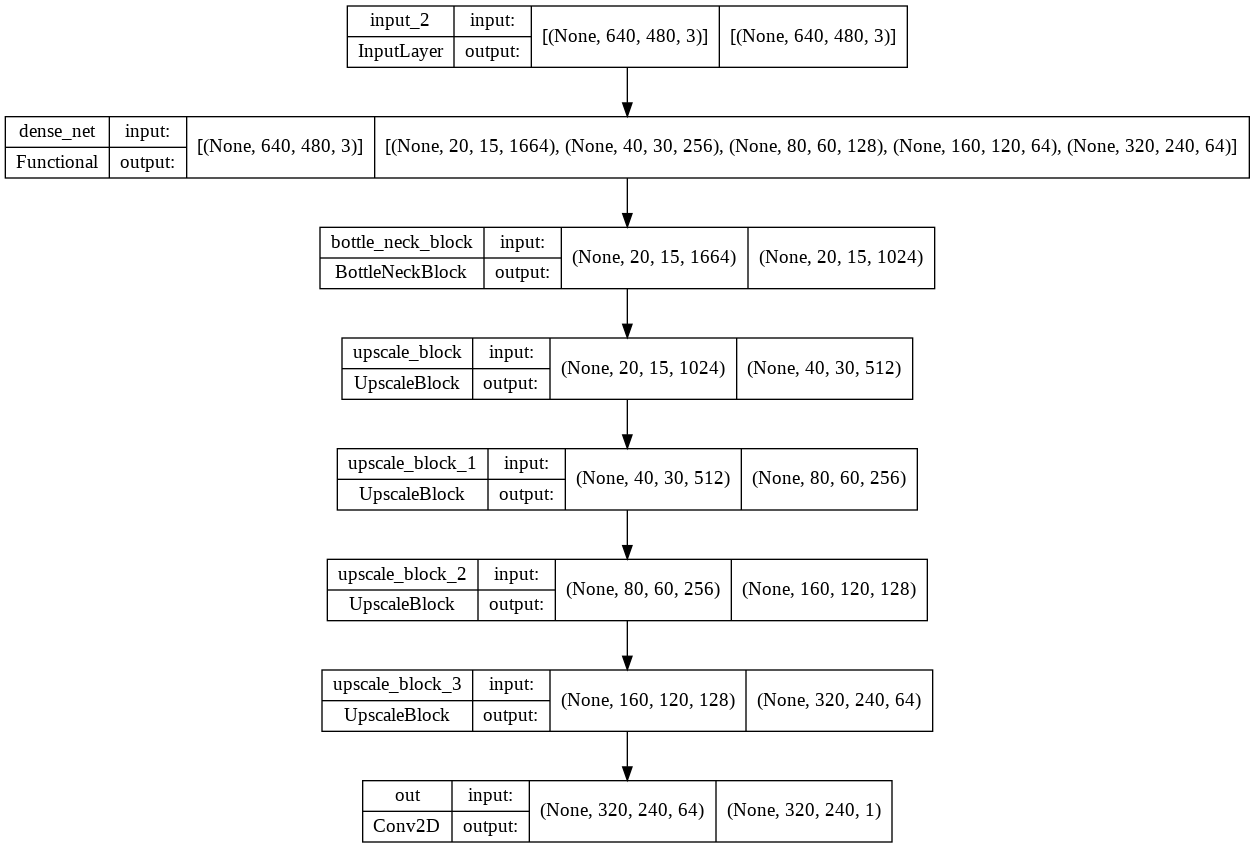

Concept: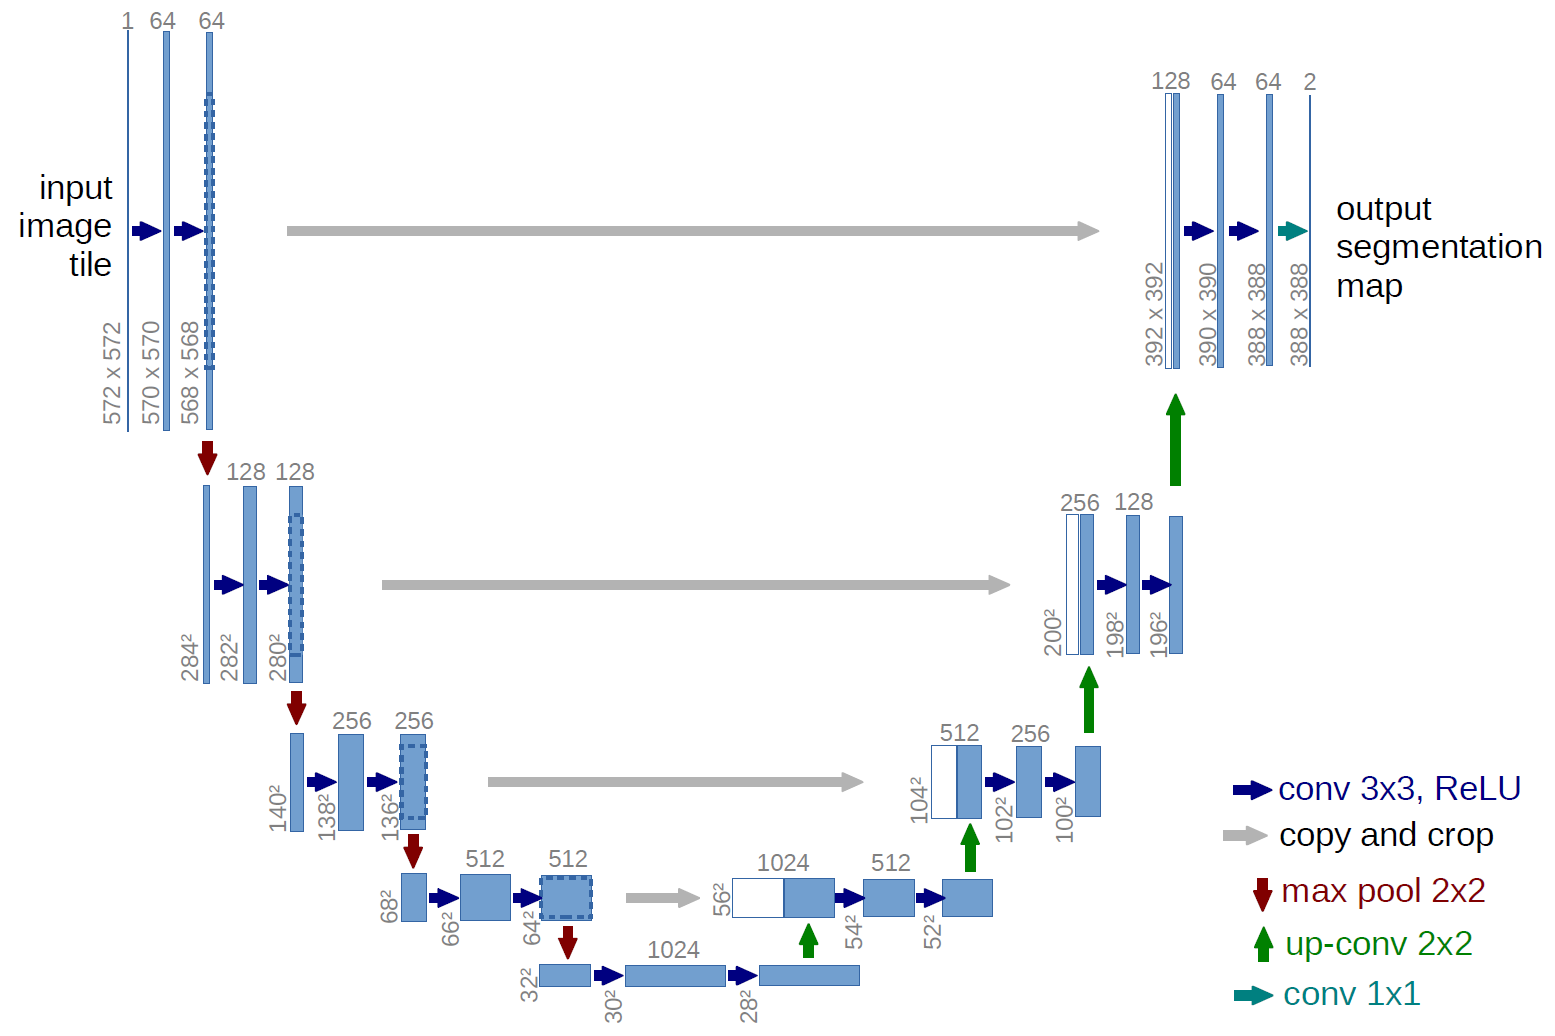

#How to run detection on a single image:
Before running the detection, the model must be loaded, this can be done using the following code: 
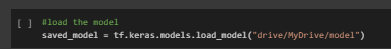

You can find it at the bottom of this google colab notebook. Remember to change the path to you model. The pretrained model can be downloaded using this link: https://drive.google.com/drive/folders/1VqxSQfWkMepXw7CeD9vY-YbuNcyhrH4s?usp=sharing

Then run the camera module code:

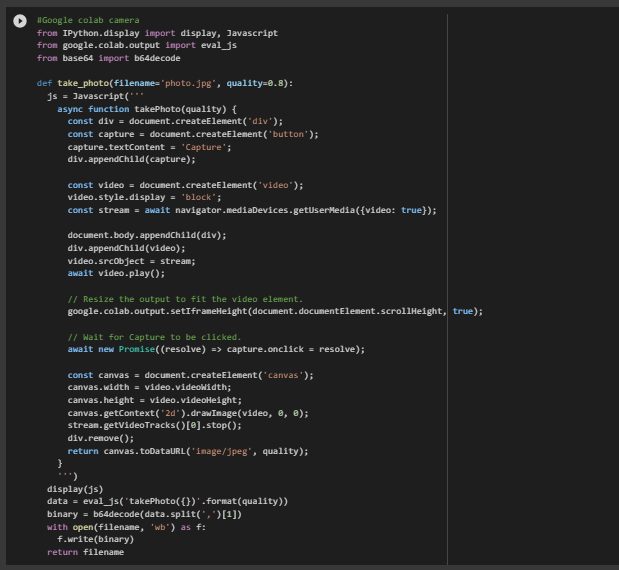

Take or upload a picture:

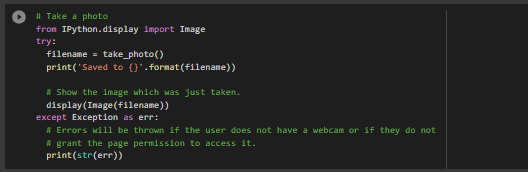

Perform the detection:

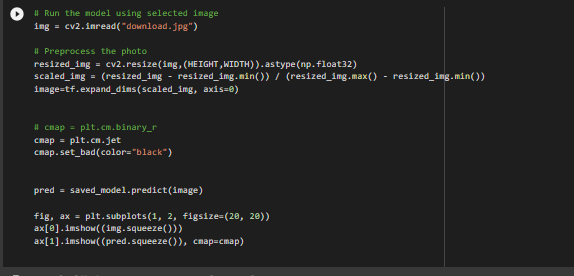

Example detections:

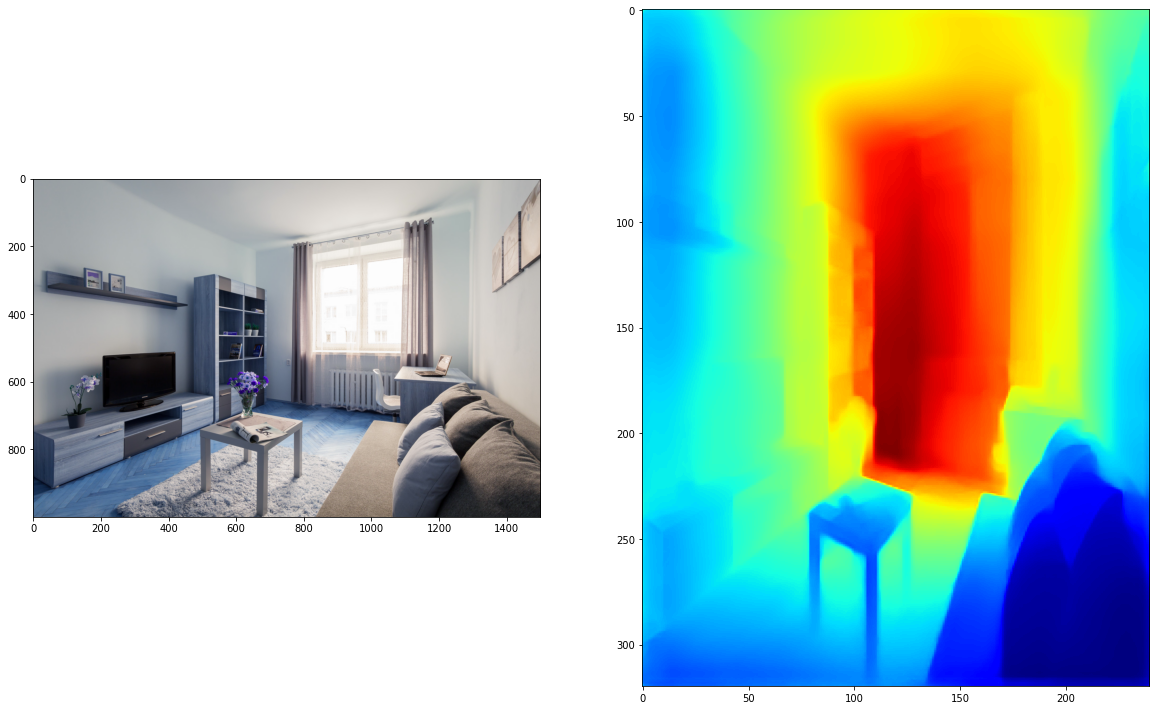

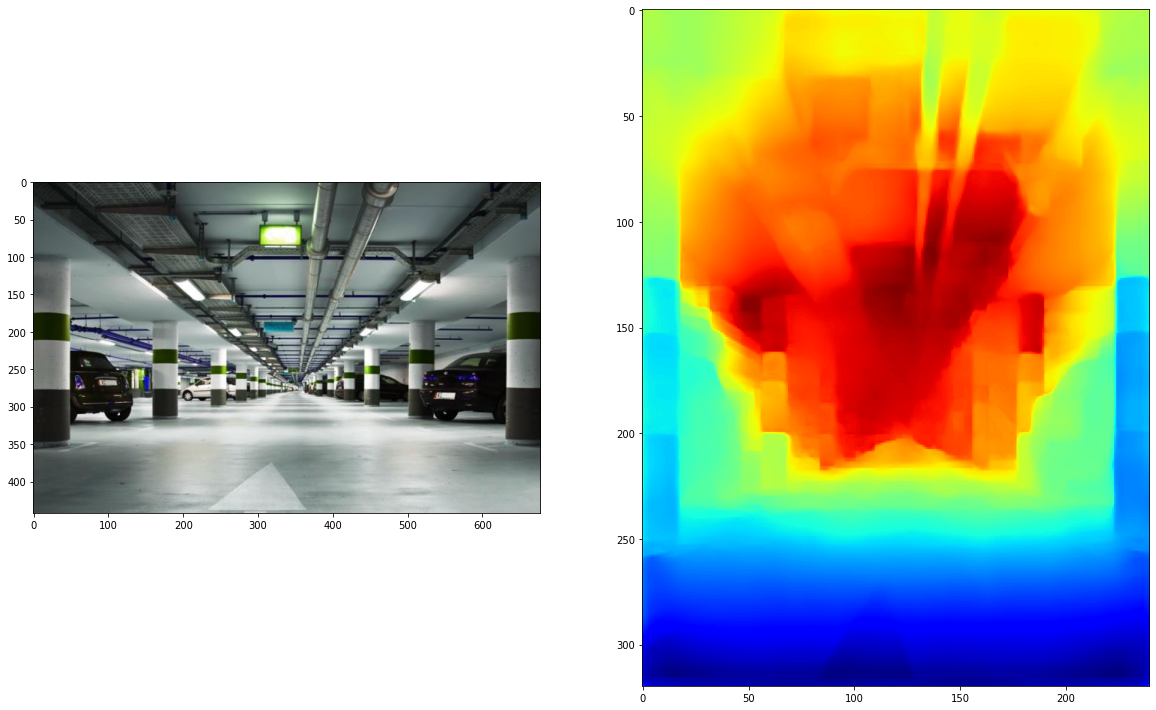

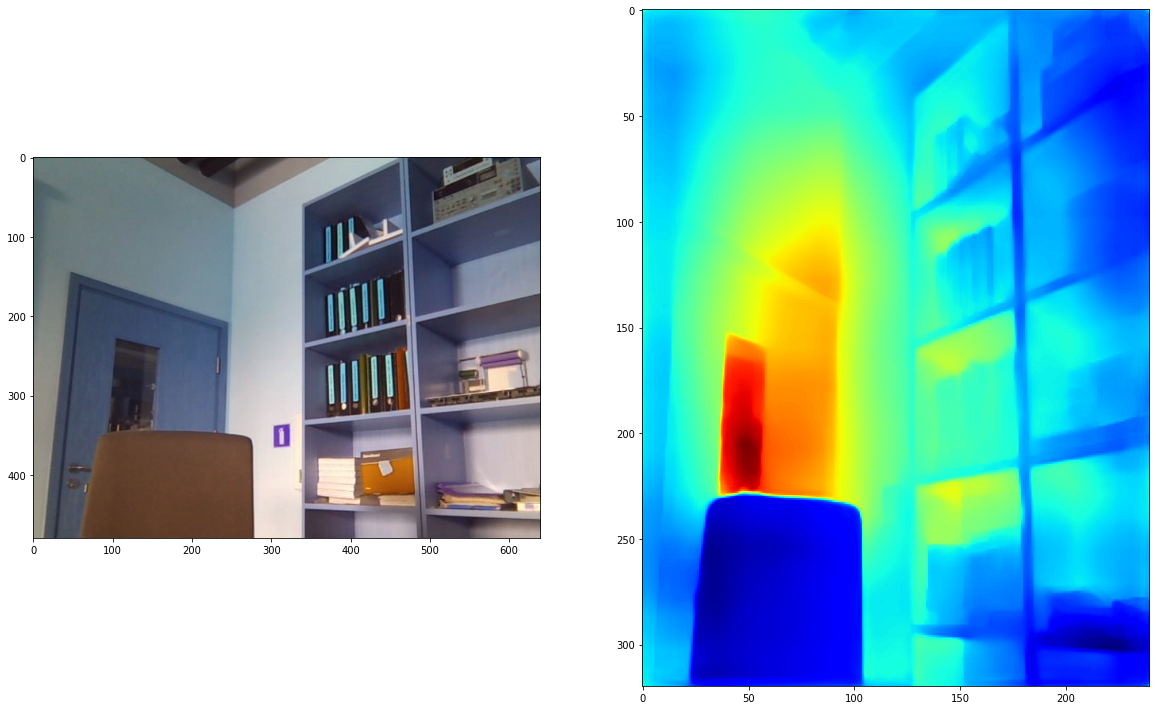



In [ ]:
 import os, sys

import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from zipfile import ZipFile

tf.random.set_seed(42)

In [ ]:
HEIGHT = 480
WIDTH = 640
LR = 0.0001
EPOCHS = 3
BATCH_SIZE = 8
TRAIN_SIZE = 0.8

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
########################################################################################
#NYU DATASET
########################################################################################
def extract_zip(src, dest):
    '''
    Extracts the contents downloaded from the URL
    '''
    zip_ref = ZipFile(src,'r')
    zip_ref.extractall(dest)
    zip_ref.close()

extract_zip('drive/MyDrive/nyu_data.zip', '')

In [ ]:
train_df = pd.read_csv('/content/data/nyu2_train.csv',header=None)
train_df = train_df.sample(frac=1).reset_index(drop=True).rename(columns={0:'image', 1:'depth'})
train_split = int(len(train_df)*TRAIN_SIZE)


train = train_df[:train_split]
validation = train_df[train_split:]
test = pd.read_csv('/content/data/nyu2_test.csv',header=None).rename(columns={0:'image', 1:'depth'})
len(train), len(validation), len(validation)

(40550, 10138, 10138)

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, dataframe, batch_size, shuffle=False, dim=(320,240)):
    # for reproducibility
    np.random.seed(43)
    # dataframe containing the subset of image and depth pairs
    self.df = dataframe
    # chosen Height and Width of the RGB image
    self.width, self.height = dim
    # choice of shuffling the data
    self.shuffle = shuffle
    self.batch_size = batch_size
    # unique set of RGB images
    self.ids = dataframe['image'].unique()
    # Map the image with depth maps
    self.imgtodpth = dataframe.set_index('image')['depth'].to_dict()
    self.on_epoch_end()

  def __len__(self):
    '''
    Returns the length of dataset.
    '''
    return len(self.df) // self.batch_size

  def on_epoch_end(self):
    '''
    Shuffles the data at the end of every epoch
    '''
    self.indexes = np.arange(len(self.ids))
    if self.shuffle:
      np.random.shuffle(self.indexes)
  
  def __getitem__(self,index):
    '''
    returns the batch of image and depth pairs 
    '''
    # select the batch of pair indexes 
    idxs = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
    # randomly select whether to flip the image
    flip = np.random.choice([True, False])
    # select the image id's for the above indexes
    query_imgs = [self.ids[idx] for idx in idxs]
    # select corresponding depth pair for the image
    target_imgs = [self.imgtodpth[img] for img in query_imgs]
    # preprocess the image 
    processed_query_img = self._preprocess_image(query_imgs, flip)
    # preprocess the depth map
    processed_depth_img = self._preprocess_depth(target_imgs, flip)
    return processed_query_img, processed_depth_img

  def _preprocess_image(self,images, flip):
    '''
    Resize, Normalize and randomly Augments the image set. 
    '''
    # placeholder for storing the processed images
    processed = []
    for img in images:
      # resize the image to 640x480
      resized_img = cv2.resize(cv2.imread(img),(self.width,self.height)).astype(np.float32)
      # normalize the image to {0,1}
      scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
      # flip the image horizontally
      if flip:
        scaled_img = cv2.flip(scaled_img, 1)
      # finally append each image
      processed.append(scaled_img)
    return np.array(processed)

  def _preprocess_depth(self,images, flip):
    '''
    Resize, Normalize and randomly Augments the depth maps.
    '''
    # placeholder for storing the processed depth maps
    processed = []
    for img in images:
      # resize the depth map to 320x240
      resized_img = cv2.resize(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2GRAY),
                              (int(self.width/2),int(self.height/2))).astype(np.float32)
      # normalize it to range {0,1}
      scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
      # flip the image horizontally
      if flip:
        scaled_img = cv2.flip(scaled_img, 1)
      # add the color channel as cv2 grayscale image doesnt contain color channel but tensorflow expects it
      scaled_img = np.expand_dims(scaled_img, axis=-1)
      # finally append the image
      processed.append(scaled_img)
    return np.array(processed)
    


In [ ]:
train_generator = DataGenerator(train, batch_size=BATCH_SIZE, shuffle=True, dim=(WIDTH,HEIGHT))
val_generator = DataGenerator(validation, batch_size=BATCH_SIZE, shuffle=False, dim=(WIDTH,HEIGHT))
test_generator = DataGenerator(test, batch_size=BATCH_SIZE, shuffle=False, dim=(WIDTH,HEIGHT))
print(len(train_generator), len(val_generator), len(test_generator))

5068 1267 81


In [ ]:
images,depths = next(iter(val_generator))
print(images.shape, depths.shape)

(8, 480, 640, 3) (8, 240, 320, 1)


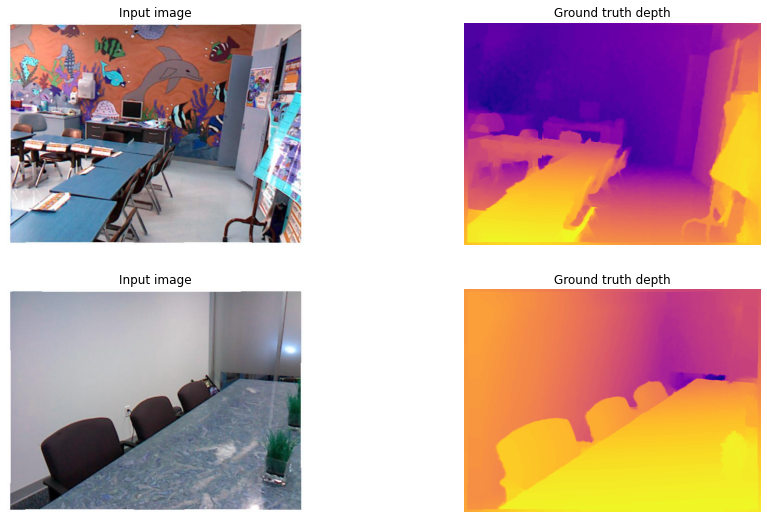

In [ ]:
cmap = "plasma_r"
plt.figure(figsize=(15,9))
for i in range(0,4,2):
  image = images[i]
  depth = depths[i].squeeze(-1)
  plt.subplot(221+i)
  plt.axis('off')
  plt.imshow(image)
  plt.title('Input image')
  plt.subplot(222+i)
  plt.axis('off')
  plt.imshow(depth,cmap=plt.get_cmap(cmap))
  plt.title('Ground truth depth')

In [ ]:
########################################################################################
#NYU DATASET
########################################################################################

In [ ]:
class UpscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conc = layers.Concatenate(axis=3)
        # self.zeropadding = layers.ZeroPadding2D((1,1))

    def call(self, x, skip):
        # x= self.zeropadding(x)
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x

    def summary(self, input_shape):
      x = tf.keras.Input(shape=input_shape)
      model = tf.keras.Model(inputs=[x], outputs=self.call(x))
      return model.summary()


class BottleNeckBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x
    def summary(self, input_shape):
      x = tf.keras.Input(shape=input_shape)
      model = tf.keras.Model(inputs=[x], outputs=self.call(x))
      return model.summary()

In [ ]:
def get_backbone():
    """Builds ResNet50 with pre-trained imagenet weights"""
    backbone = tf.keras.applications.DenseNet169(include_top=False,
                                                          weights="imagenet",
                                                          input_shape = (WIDTH,HEIGHT,3))

    c0_output, c1_output, c2_output, c3_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ['pool3_pool', 'pool2_pool','pool1','conv1/relu']
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[backbone.output, c0_output, c1_output,
                                           c2_output, c3_output]
    )

class DensePretrainedDepthEstimationModel(tf.keras.Model):
    def __init__(self, ssim_loss_weight = 0.85,
                 l1_loss_weight = 0.02, edge_loss_weight = 1.5):
        super(DensePretrainedDepthEstimationModel, self).__init__(name = "Test_Model")
        
        self.ssim_loss_weight = ssim_loss_weight
        self.l1_loss_weight = l1_loss_weight
        self.edge_loss_weight = edge_loss_weight
        self.loss_metric = tf.keras.metrics.Mean(name="loss")


        # f = [104, 208, 416, 832, 1664]
        f = [64, 128, 256, 512, 1024]

        self.densenet_net =  get_backbone()

        self.densenet_net._name = 'dense_net'

        # for layer in self.densenet_blocks.layers:
        #   layer.trainable = False
        
        self.bottle_neck_block = BottleNeckBlock(f[4])

        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")
        self.conv_layer._name = 'out'
    

    def calculate_loss(self, target, pred):
        #distance loss
        l_depth = K.mean(K.abs(pred - target), axis=-1)
        
        # edge loss for sharp edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)
        
        # structural similarity loss
        l_ssim = K.clip((1 - tf.image.ssim(target, pred, 1.0)) * 0.5, 0, 1)

        # weights
        w1, w2, w3 = 1.0, 1.0, 0.1

        loss = (w1 * l_ssim) + (w2 * l_edges) + (w3 * l_depth)
        # loss = (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))
        return loss, l_depth


    
    # accuracy function
    def accuracy_function(self, y_true, y_pred):
        return K.mean(K.equal(K.round(y_true), K.round(y_pred)))  

    @property
    def metrics(self):
        return [self.loss_metric]
    @tf.function
    def train_step(self, batch_data):
        input, target = batch_data
        with tf.GradientTape() as tape:
            tape.watch(input)
            pred = self(input, training=True)
            loss, l1_loss = self.calculate_loss(target, pred)
        
        trainable_vars = self.trainable_weights
        gradients = tape.gradient(loss, trainable_vars)
        
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
            "Accuracy":  self.accuracy_function(target, pred),
        }


    def test_step(self, batch_data):
        input, target = batch_data
        pred = self(input, training=False)
        loss, l1_loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
             "Accuracy":  self.accuracy_function(target, pred),
        }

    def call(self, x):
        out, s1,s2,s3, s4 = self.densenet_net(x)
        b = self.bottle_neck_block(out)
        u1 = self.upscale_blocks[0](b, s1)
        u2 = self.upscale_blocks[1](u1, s2)
        u3 = self.upscale_blocks[2](u2, s3)
        u4 = self.upscale_blocks[3](u3, s4)

        return self.conv_layer(u4)

    def summary(self, input_shape):
      x = tf.keras.Input(shape=input_shape)
      model = tf.keras.Model(inputs=[x],outputs=self.call(x))

      model.summary() # This will print the summary properly
      tf.keras.utils.plot_model(model,show_shapes=True)




In [ ]:
# Train the model
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    amsgrad=False,
    epsilon=1e-08,
)



model = DensePretrainedDepthEstimationModel()

model.build(input_shape=(None, WIDTH, HEIGHT, 3))
model.summary(input_shape=(WIDTH, HEIGHT, 3))

# save model frequently for later use.
checkpoint = tf.keras.callbacks.ModelCheckpoint('drive/MyDrive/depth_extimation',
                                                save_best_only=True,
                                                verbose=1)
# Learning rate scheduler
def polynomial_decay(epoch):
  max_epochs = EPOCHS
  base_lr =  LR
  power = 1.0
  lr = base_lr * (1 - (epoch / float(max_epochs))) ** power
  return lr

callbacks = [tf.keras.callbacks.LearningRateScheduler(polynomial_decay, verbose=1), checkpoint]

# Compile the model
model.compile(optimizer)

# model.fit(
#     train_generator,
#     epochs=EPOCHS,
#     validation_data=val_generator,
#     callbacks=callbacks,
# )

51888128/51877672 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 640, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 dense_net (Functional)         [(None, 20, 15, 166  12642880    ['input_2[0][0]']                
                                4),                                                               
                                 (None, 40, 30, 256                                               
                                ),                                                                
                           

In [ ]:
#Test the model
model.evaluate(test_generator)

81/81 [==============================] - 29s 349ms/step - loss: 0.1517 - Accuracy: 0.8578


[0.1517043113708496, 0.9082795977592468]

In [ ]:
#Save the model
model.save("model")
!zip -r model.zip model

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [ ]:
#load the model
saved_model = tf.keras.models.load_model("drive/MyDrive/model")

In [ ]:
#Google colab camera
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


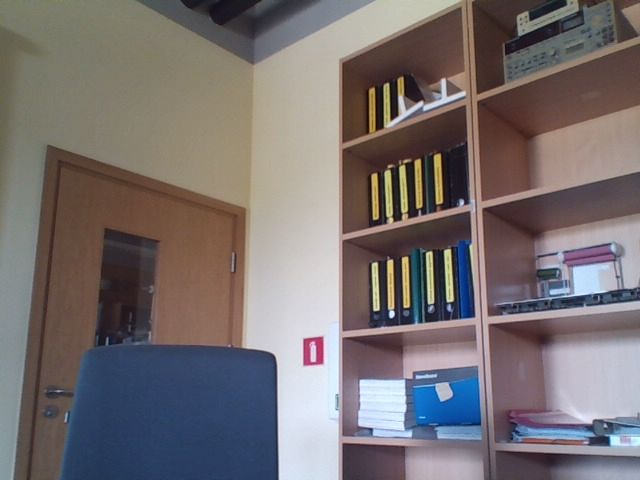

In [ ]:
# Take a photo
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

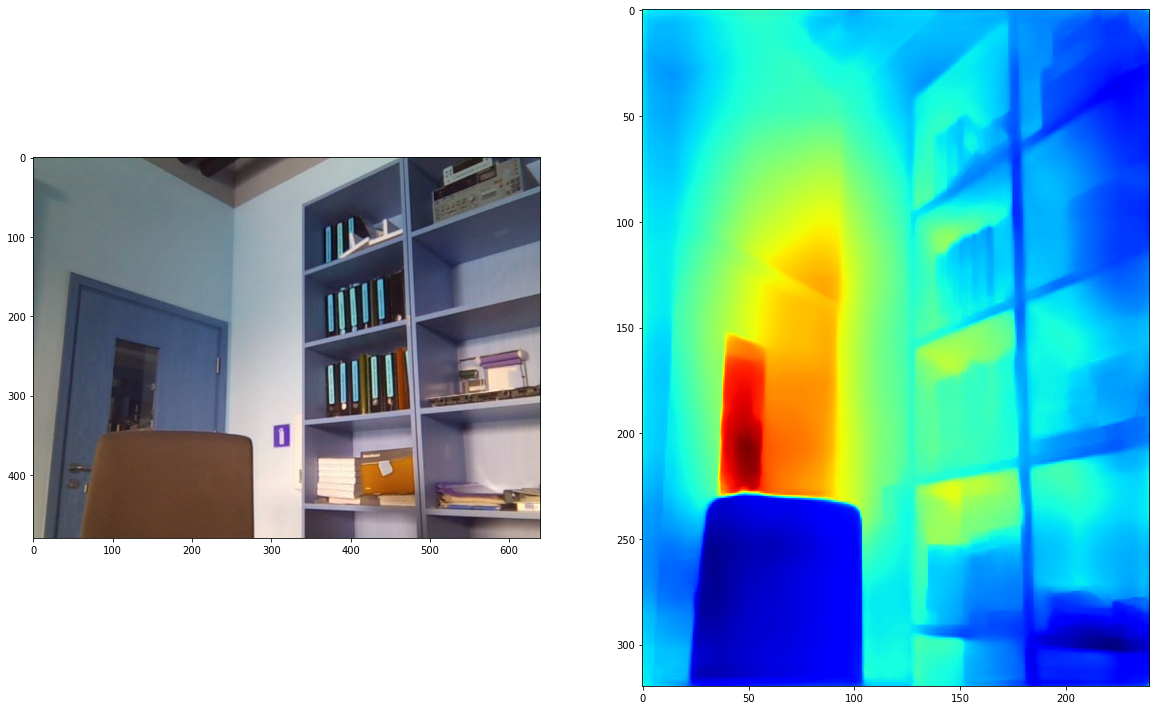

In [ ]:
# Run the model using selected image
img = cv2.imread("download.jpg")

# Preprocess the photo
resized_img = cv2.resize(img,(HEIGHT,WIDTH)).astype(np.float32)
scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
image=tf.expand_dims(scaled_img, axis=0)


# cmap = plt.cm.binary_r
cmap = plt.cm.jet
cmap.set_bad(color="black")


pred = saved_model.predict(image)

fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow((img.squeeze()))
ax[1].imshow((pred.squeeze()), cmap=cmap)
